## Environment Setup


In [1]:
%load_ext watermark


In [2]:
import itertools as it
import functools
import random
from typing import Dict, List, Sequence, Tuple, Union
import uuid


try:
  import cupy as cp
except ImportError:
  import numpy as cp
from IPython.display import display_html
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm.auto import tqdm


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
teeplot_subdir = "2026-02-09-allele-abm"


In [4]:
%watermark -diwmuv -iv


Last updated: 2026-02-23T16:33:51.190352+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1044-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn: 0.13.2
pandas : 2.2.3
numpy  : 2.1.2
teeplot: 1.4.2

Watermark: 2.4.3



In [5]:
use_cupy = False  # use cupy backend (GPU), otherwise use numpy (CPU)
xp = [np, cp][use_cupy]


## Simulation Implementation


In [6]:
@functools.lru_cache(maxsize=None)
def simulate(
    N_SITES: int=2,
    POP_SIZE: int=1_000_000,
    CONTACT_RATE: float=0.3,
    RECOVERY_RATE: float=0.1,
    MUTATION_RATE: Union[float, Sequence[float]]=1e-4,
    WANING_RATE: float=0.02,
    IMMUNE_STRENGTH: float=0.9,
    N_STEPS: int=1_000,
    SEED_COUNT: int=10,
    within_host_b: float=0.2,
    within_host_t: float=25.0,
    seed: int=1,
    MUTATOR_HOSTS_N: int=0,
    MUTATOR_HOSTS_MX: float=1.0,
) -> pd.DataFrame:
    random.seed(seed)
    np.random.seed(seed)
    xp.random.seed(seed)

    MUTATION_RATE = xp.asarray(MUTATION_RATE, dtype=xp.float32)

    if N_SITES > 8:
      raise NotImplementedError(
          "current data types support only up to 8 sites",
      )

    def initialize_pop() -> Tuple[xp.ndarray, xp.ndarray, xp.ndarray]:
        """Initialize population statuses, genomes, and immune history."""
        pathogen_genomes = xp.zeros(shape=POP_SIZE, dtype=xp.uint8)
        # host_immunities: Tracks each of the 2*N_SITES alleles
        host_immunities = xp.full(
            shape=(POP_SIZE, 2 * N_SITES), fill_value=0.0, dtype=xp.float32
        )
        # host_statuses: days since infection (0 if not infected)
        host_statuses = xp.full(shape=POP_SIZE, fill_value=0, dtype=xp.uint8)

        return host_statuses, pathogen_genomes, host_immunities

    def infect_initial(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray]:
        """Seed the initial infection wave with the starting strain."""
        # pick randomly
        seeded_indices = xp.random.choice(POP_SIZE, size=SEED_COUNT, replace=False)
        host_statuses[seeded_indices] = 1
        pathogen_genomes[seeded_indices] = 0  # wildtype
        return host_statuses, pathogen_genomes

    def calc_infection_probabilities(
        host_immunities: xp.ndarray,
        pathogen_genomes: xp.ndarray,
    ) -> xp.ndarray:
        host_susceptibilities = xp.reshape(
            1.0 - (IMMUNE_STRENGTH * host_immunities), (POP_SIZE, 2 * N_SITES)
        )

        pathogen_bits = (pathogen_genomes[:, None] >> xp.arange(N_SITES)) & 1
        pathogen_alleles = (pathogen_bits[:, :, None] == xp.array([0, 1])).reshape(-1, 2 * N_SITES)

        active_susc = xp.where(pathogen_alleles, host_susceptibilities, 1.0)
        res = xp.prod(active_susc, axis=1)
        assert res.shape == (POP_SIZE,)
        return res

    if MUTATION_RATE.size == 1:
        def calc_mutation_probabilities(
            host_immunities: xp.ndarray,
            pathogen_genomes: xp.ndarray,
        ) -> xp.ndarray:
            # pathogen_bits: (N_Infected, N_SITES) - 0 or 1 for each site
            pathogen_bits = (pathogen_genomes[:, None] >> xp.arange(N_SITES)) & 1

            # Reshape immunities to (N_Infected, N_SITES, 2) to easily pick bits
            imm_reshaped = xp.reshape(host_immunities, (-1, N_SITES, 2))

            # Pick the immunity of the CURRENT allele and the OPPOSITE allele
            # We add a trailing dimension to pathogen_bits to use with take_along_axis
            idx_curr = pathogen_bits[:, :, None]
            idx_opp = 1 - idx_curr

            imm_curr = xp.take_along_axis(imm_reshaped, idx_curr, axis=2).squeeze(axis=2)
            imm_opp = xp.take_along_axis(imm_reshaped, idx_opp, axis=2).squeeze(axis=2)

            # Difference determines the mutation pressure
            host_immunity_deltas = imm_curr - imm_opp

            b_values = 1.0 + within_host_b * host_immunity_deltas
            # Safety: prevent division by zero or negative b if using specific growth models
            b_values = xp.where(xp.abs(b_values - 1.0) < 1e-7, 1.000001, b_values)

            # \frac{y}{x} = \frac{m}{b-1} \left( e^{(b-1)t} - 1 \right)
            return (MUTATION_RATE / (b_values - 1.0)) * (xp.exp((b_values - 1.0) * within_host_t) - 1.0)

    else:
        def calc_mutation_probabilities(
            host_immunities: xp.ndarray,
            pathogen_genomes: xp.ndarray,
        ) -> xp.ndarray:
            # Calculate number of currently infected hosts being processed
            n_infected = host_immunities.shape[0]

            # MUTATION_RATE is shape (N_SITES,)
            # We expand it to shape (n_infected, N_SITES)
            # Creating a column of ones and multiplying allows robust broadcasting
            return xp.ones((n_infected, 1), dtype=MUTATION_RATE.dtype) * MUTATION_RATE

    def update_waning(host_immunities: xp.ndarray) -> xp.ndarray:
        """Decay immunity levels over time."""
        host_immunities *= (1.0 - WANING_RATE)
        return host_immunities

    def update_recoveries(
        host_statuses: xp.ndarray,
        host_immunities: xp.ndarray,
        pathogen_genomes: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray]:
        """Recover infected individuals and reset allele immunity to Level 2."""

        # who has recovered?
        recovered_mask = (host_statuses > 1 / RECOVERY_RATE).astype(bool)

        # set immunity to 1.0 for recovered individuals
        pathogen_bits = (pathogen_genomes[:, None] >> xp.arange(N_SITES)) & 1
        pathogen_alleles = (pathogen_bits[:, :, None] == xp.array([0, 1])).reshape(-1, 2 * N_SITES)

        assert np.all(
            pathogen_alleles[recovered_mask].sum(axis=1) == N_SITES
        )

        host_immunities[
            pathogen_alleles.astype(bool)
            & recovered_mask[:, None]
        ] = 1.0

        # Increment days since infection
        host_statuses += (host_statuses > 0).astype(xp.uint8)
        host_statuses[recovered_mask] = 0

        return host_statuses, host_immunities

    def transmit_infection(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
        host_immunities: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray]:
        """Vectorized transmission based on allele-specific susceptibility."""
        contacts = xp.random.randint(low=0, high=POP_SIZE, size=POP_SIZE, dtype=xp.uint32)
        inf_probs = (
            calc_infection_probabilities(host_immunities, pathogen_genomes[contacts])
            * (host_statuses == 0)
            * (host_statuses[contacts] > 0)
            * CONTACT_RATE
        )

        new_infections = xp.random.rand(POP_SIZE) < inf_probs
        host_statuses[new_infections] = 1
        pathogen_genomes[new_infections] = pathogen_genomes[contacts][new_infections]

        return host_statuses, pathogen_genomes

    def apply_mutations(
        pathogen_genomes: xp.ndarray,
        host_statuses: xp.ndarray,
    ) -> xp.ndarray:
        """Apply mutations to newly infected individuals."""
        mutation_mask = (host_statuses == 1).astype(bool)

        mprobs = calc_mutation_probabilities(host_immunities[mutation_mask], pathogen_genomes[mutation_mask])
        mutator_n = host_statuses[:MUTATOR_HOSTS_N].sum()
        mprobs[:mutator_n] = xp.minimum(mprobs[:mutator_n] * MUTATOR_HOSTS_MX, 1.0)

        for s in range(N_SITES):
            mutation_occurs = (xp.random.rand(mprobs.shape[0]) < mprobs[:, s]).astype(xp.uint8)
            pathogen_genomes[mutation_mask] ^= (mutation_occurs << s).astype(xp.uint8)

        return pathogen_genomes

    def update_simulation(
        host_statuses: xp.ndarray,
        pathogen_genomes: xp.ndarray,
        host_immunities: xp.ndarray,
    ) -> Tuple[xp.ndarray, xp.ndarray, xp.ndarray]:
        """Run one step of the simulation."""
        host_statuses, pathogen_genomes = transmit_infection(
            host_statuses, pathogen_genomes, host_immunities
        )
        pathogen_genomes = apply_mutations(pathogen_genomes, host_statuses)
        host_statuses, host_immunities = update_recoveries(host_statuses, host_immunities, pathogen_genomes)
        host_immunities = update_waning(host_immunities)

        return host_statuses, pathogen_genomes, host_immunities

    host_statuses, pathogen_genomes, host_immunities = initialize_pop()
    host_statuses, pathogen_genomes = infect_initial(host_statuses, pathogen_genomes)
    data_log: List[Dict[str, float]] = []

    for t in tqdm(range(N_STEPS)):

        # update simulation
        host_statuses, pathogen_genomes, host_immunities = update_simulation(
            host_statuses, pathogen_genomes, host_immunities
        )

        # 1. Strain Prevalence (Frequency of each unique genome in the infected pop)
        inf_mask = host_statuses > 0
        counts_dict: Dict[str, float] = {}

        if xp.any(inf_mask):
            unique_g, counts = xp.unique(pathogen_genomes[inf_mask], return_counts=True)

            # Create a string representation of the genome (e.g., "010")
            # This is more standard for "strains" than allele indices
            for g, count in zip(unique_g.tolist(), counts.tolist()):
                # Convert genome integer to bitstring padded to N_SITES
                fmt = f'0{N_SITES}b'
                strain_name = format(int(g), fmt)[::-1] # Reverse to match bit-shift order
                counts_dict[f"Strain_{strain_name}"] = float(count) / POP_SIZE

        # 2. Host Susceptibility per Allele
        # host_immunities is already (POP_SIZE, 2 * N_SITES)
        # Susceptibility = 1 - (IMMUNE_STRENGTH * immunity_level)
        avg_susc = xp.mean(1.0 - (IMMUNE_STRENGTH * host_immunities), axis=0)

        # Map to specific allele names (Site_0_Bit_0, Site_0_Bit_1, etc.)
        immunity_dict = {}
        for i in range(2 * N_SITES):
            site = i // 2
            bit = i % 2
            immunity_dict[f"Susc_S{site}_B{bit}"] = float(avg_susc[i])

        # 3. Aggregate Metrics
        log_entry = {
            "Step": t,
            "Seed": seed,
            "Total_Infected": float(xp.sum(inf_mask)) / POP_SIZE
        }
        log_entry.update(counts_dict)
        log_entry.update(immunity_dict)
        data_log.append(log_entry)

    return pd.DataFrame(data_log).fillna(0).copy()


## Plotting Implementation


In [7]:
def render_timeseries_plots(
    df: pd.DataFrame,
    suptitle: str,
    teeplot_outattrs: dict,
) -> None:
    for what, row in it.product(
        ["Susc", "Strain"],
        ["Seed", None],
    ):
      data = df.filter(
          regex=f"Step|Seed|{what}", axis=1
      ).melt(
          id_vars=["Step", "Seed"], var_name="Class", value_name="Prevalence"
      ).astype(
          {"Step": int, "Class": str, "Prevalence": float},
      )
      data["Ham. Wt."] = data["Class"].str.count("1|3|5|7|9")
      palette = dict(zip(
          data["Class"].unique(),
          sns.color_palette("colorblind", len(data["Class"].unique())),
      ))
      with tp.teed(
          sns.relplot,
          data=data,
          x="Step",
          y="Prevalence",
          hue="Class",
          row=row,
          alpha=0.8,
          dashes=False,
          errorbar=("pi", 100),
          err_kws=dict(alpha=0.1),
          estimator=np.median,
          facet_kws=dict(
            margin_titles = True,
          ),
          kind="line",
          palette=palette,
          teeplot_outattrs={
              **teeplot_outattrs,
              "what": what,
          },
          teeplot_subdir=teeplot_subdir,
      ) as g:
        for ax in g.axes.flat:
          ax.grid(True, alpha=0.3)
        g.figure.set_size_inches(w=4, h=1.5)
        sns.move_legend(g, "center left", bbox_to_anchor=(0.9, 0.5), frameon=False)

      with tp.teed(
          sns.relplot,
          data=data.groupby(["Step", "Seed"]).agg(
              Prevalence=("Prevalence", "sum")
          ).reset_index(),
          x="Step",
          y="Prevalence",
          row=row,
          alpha=0.8,
          dashes=False,
          errorbar=("pi", 100),
          err_kws=dict(alpha=0.1),
          estimator=np.median,
          facet_kws=dict(
            margin_titles = True,
          ),
          kind="line",
          legend=False,
          palette=palette,
          teeplot_outattrs={
              **teeplot_outattrs,
              "what": what,
          },
          teeplot_subdir=teeplot_subdir,
      ) as g:
        for ax in g.axes.flat:
          ax.grid(True, alpha=0.3)
        g.figure.set_size_inches(w=4, h=1.5)
        g.figure.suptitle("SUM")

      with tp.teed(
          sns.relplot,
          data=data,
          x="Step",
          y="Prevalence",
          hue="Class",
          col="Ham. Wt.",
          row=row,
          alpha=0.8,
          dashes=False,
          errorbar=("pi", 100),
          err_kws=dict(alpha=0.1),
          estimator=np.median,
          facet_kws=dict(
            margin_titles = True,
          ),
          kind="line",
          palette=palette,
          teeplot_outattrs={
              **teeplot_outattrs,
              "what": what,
          },
          teeplot_subdir=teeplot_subdir,
      ) as g:
        g.map_dataframe(
            sns.lineplot,
            x="Step",
            y="Prevalence",
            hue="Class",
            style="Seed",
            alpha=0.7,
            dashes=False,
            errorbar=None,
            legend=False,
            linestyle=":",
            linewidth=0.6,
            palette=palette,
        )
        for ax in g.axes.flat:
          ax.grid(True, alpha=0.3)
        if what == "Strain":
          g.set(yscale="log")

        g.set(ylim=(1/POP_SIZE, 1.1))
        g.figure.suptitle(suptitle)
        if row is not None:
          g.figure.subplots_adjust(hspace=0.16, top=0.9)
          g.figure.set_size_inches(w=5, h=5)
        else:
          g.figure.subplots_adjust(top=0.7)
          g.figure.set_size_inches(w=5, h=2)

        sns.move_legend(g, "center left", bbox_to_anchor=(0.9, 0.5), frameon=False)

      with tp.teed(
          sns.relplot,
          data=data.groupby(["Step", "Seed"]).agg(
              Prevalence=("Prevalence", "sum")
          ).reset_index(),
          x="Step",
          y="Prevalence",
          row=row,
          alpha=0.8,
          dashes=False,
          errorbar=("pi", 100),
          err_kws=dict(alpha=0.1),
          estimator=np.median,
          facet_kws=dict(
            margin_titles = True,
          ),
          kind="line",
          legend=False,
          palette=palette,
          teeplot_outattrs={
              **teeplot_outattrs,
              "what": what,
          },
          teeplot_subdir=teeplot_subdir,
      ) as g:
        for ax in g.axes.flat:
          ax.grid(True, alpha=0.3)
        if what == "Strain":
          g.set(yscale="log")

        g.set(ylim=(1/POP_SIZE, 1.1))
        g.figure.suptitle(f"SUM {suptitle}")
        if row is not None:
          g.figure.subplots_adjust(hspace=0.16, top=0.9)
          g.figure.set_size_inches(w=5, h=5)
        else:
          g.figure.subplots_adjust(top=0.7)
          g.figure.set_size_inches(w=5, h=2)


## Run Simulation and Render Plots across Condition Matrix


  0%|          | 0/2 [00:00<?, ?it/s]

Pop Size: 0.1M., Mutation Rate: 1e-07, Num Sites: 3, Mutator Hosts N: 0, MX: 1000


100%|██████████| 600/600 [00:11<00:00, 54.50it/s]

100%|██████████| 600/600 [00:10<00:00, 54.61it/s]

100%|██████████| 600/600 [00:10<00:00, 54.97it/s]

100%|██████████| 600/600 [00:10<00:00, 55.19it/s]

100%|██████████| 600/600 [00:10<00:00, 55.12it/s]

100%|██████████| 600/600 [00:10<00:00, 55.42it/s]

100%|██████████| 600/600 [00:10<00:00, 55.38it/s]

100%|██████████| 600/600 [00:10<00:00, 55.46it/s]

100%|██████████| 600/600 [00:10<00:00, 55.08it/s]

100%|██████████| 600/600 [00:11<00:00, 54.29it/s]


teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


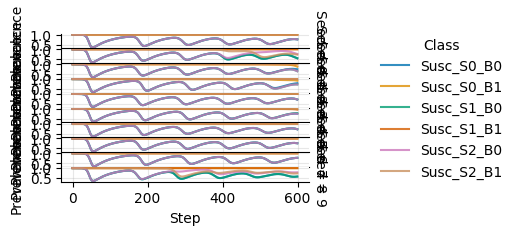

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


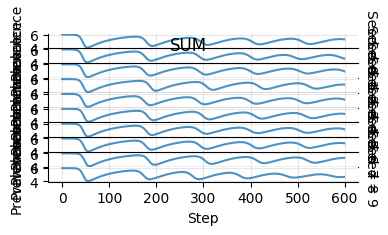

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


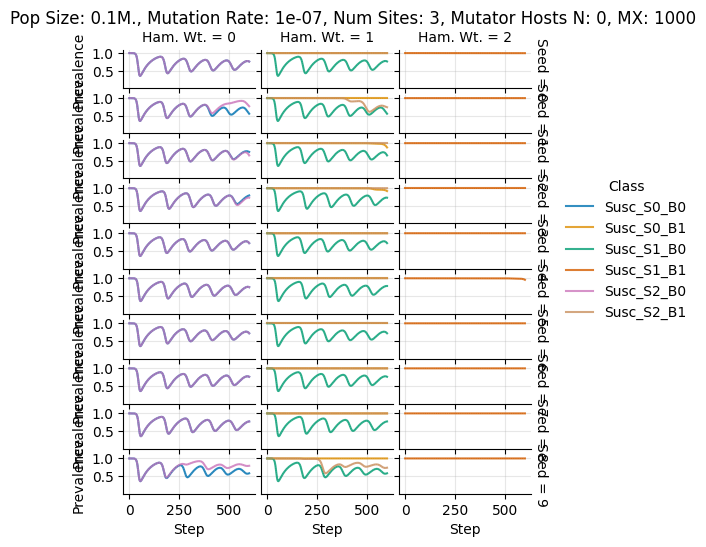

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


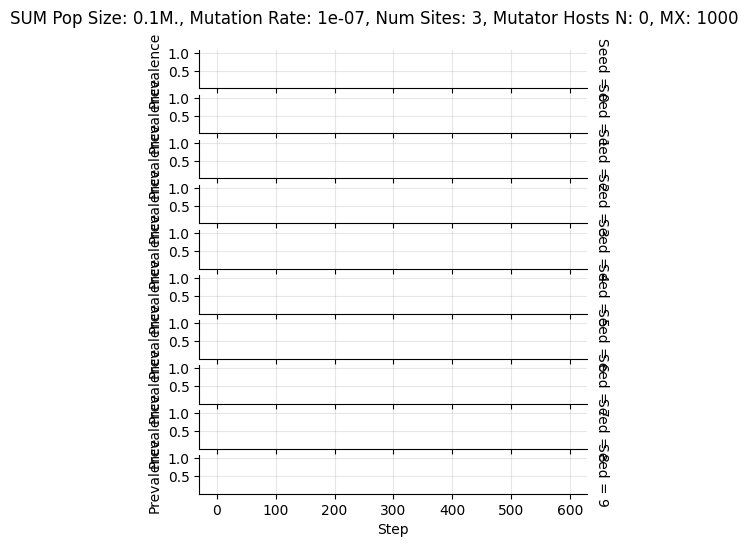

teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


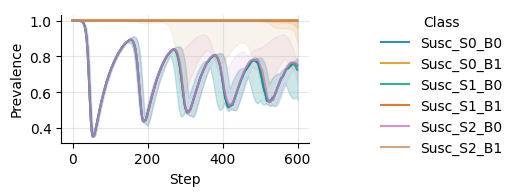

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


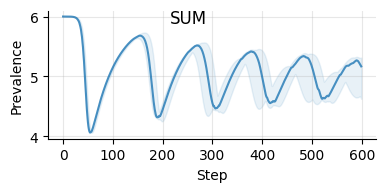

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


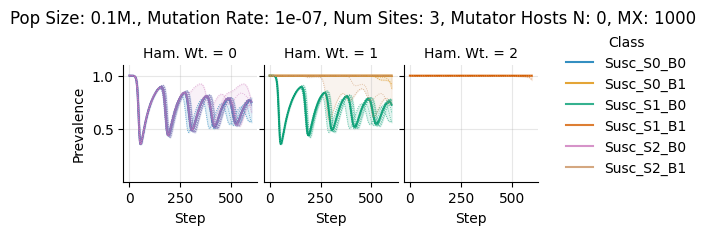

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


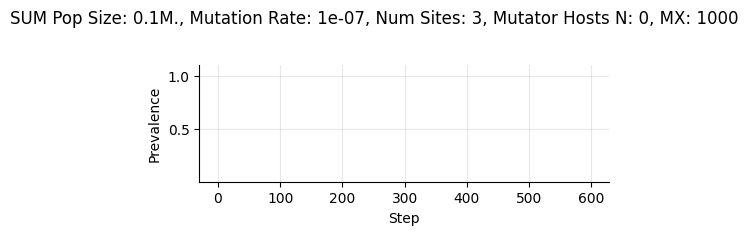

teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


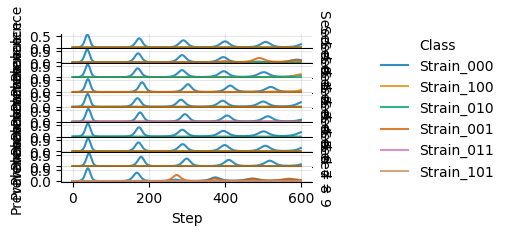

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


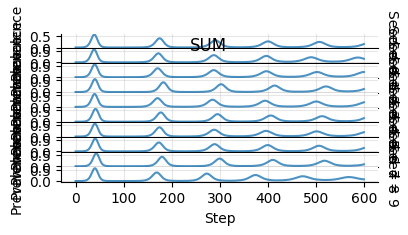

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


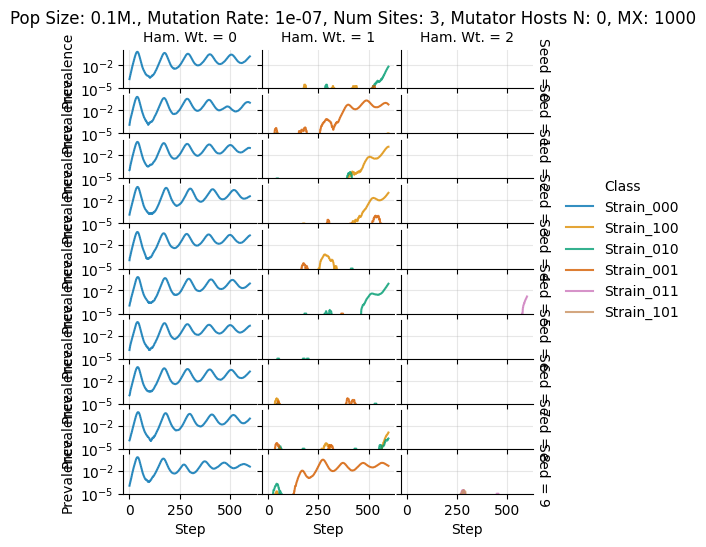

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


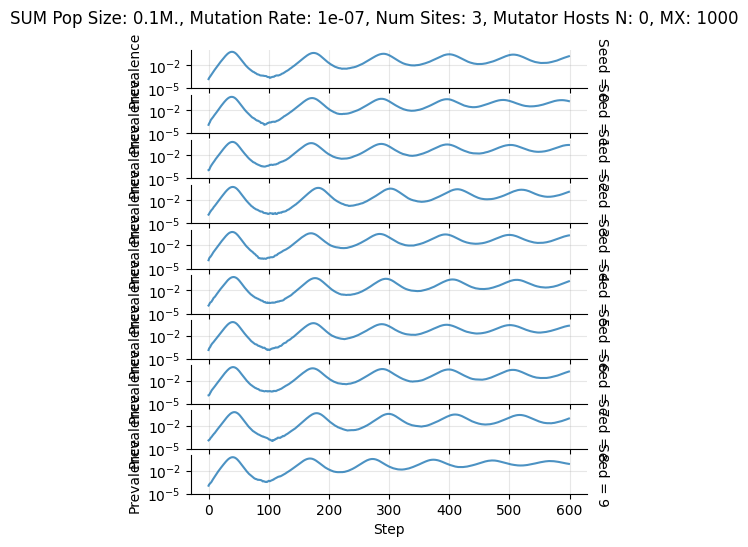

teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


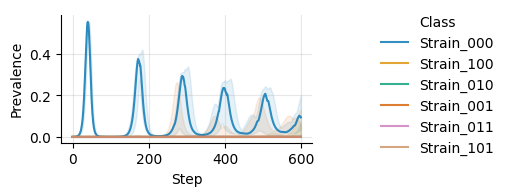

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


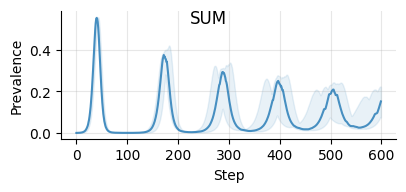

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


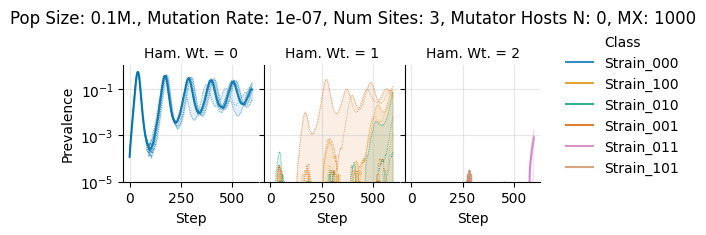

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=0+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


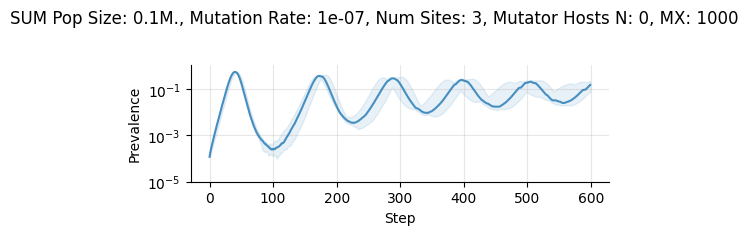

 50%|█████     | 1/2 [02:36<02:36, 156.63s/it]

Pop Size: 0.1M., Mutation Rate: 1e-07, Num Sites: 3, Mutator Hosts N: 1000, MX: 1000


100%|██████████| 600/600 [00:10<00:00, 57.45it/s]

100%|██████████| 600/600 [00:10<00:00, 56.94it/s]

100%|██████████| 600/600 [00:10<00:00, 57.27it/s]

100%|██████████| 600/600 [00:10<00:00, 56.97it/s]

100%|██████████| 600/600 [00:10<00:00, 55.81it/s]

100%|██████████| 600/600 [00:10<00:00, 56.25it/s]

100%|██████████| 600/600 [00:10<00:00, 57.46it/s]

100%|██████████| 600/600 [00:10<00:00, 56.43it/s]

100%|██████████| 600/600 [00:10<00:00, 57.41it/s]

100%|██████████| 600/600 [00:10<00:00, 56.57it/s]


teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


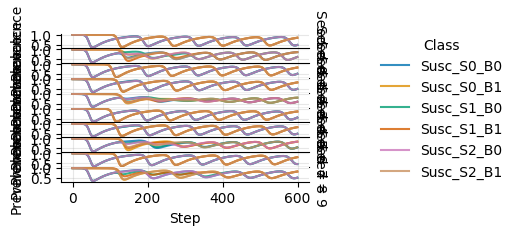

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


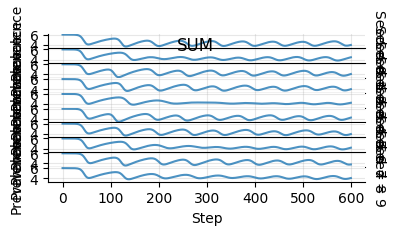

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


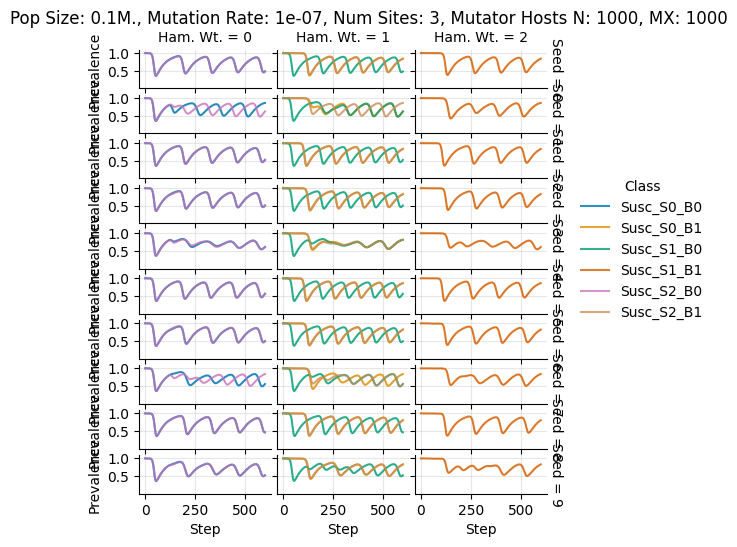

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


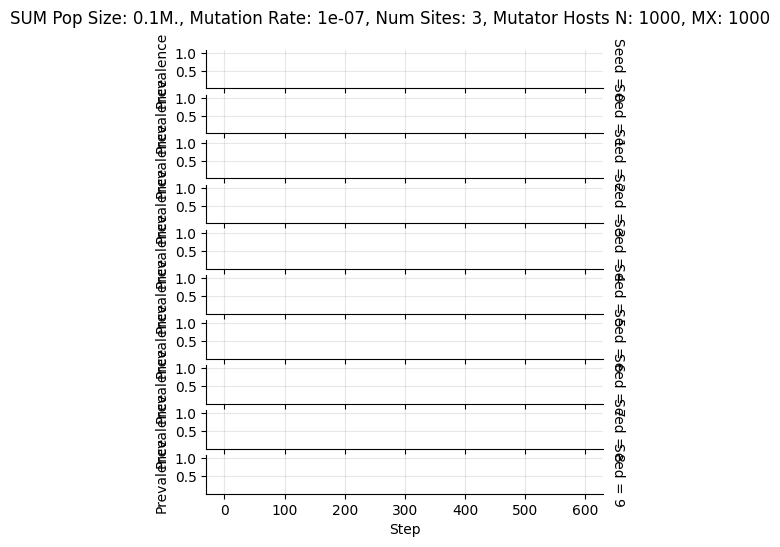

teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


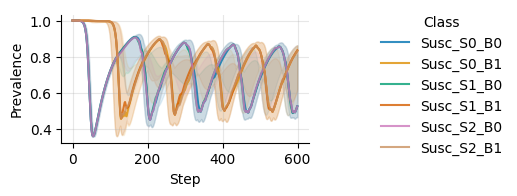

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


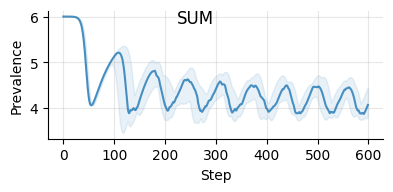

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


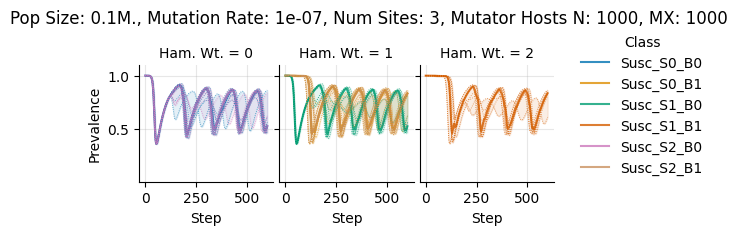

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Susc+x=step+y=prevalence+ext=.png


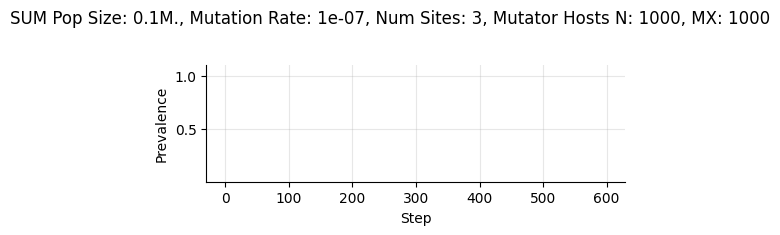

teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


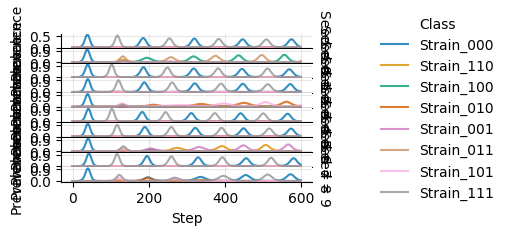

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


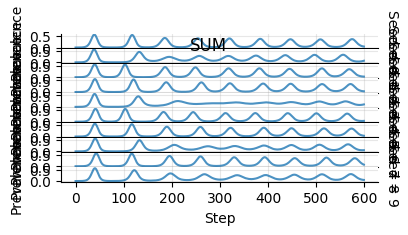

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


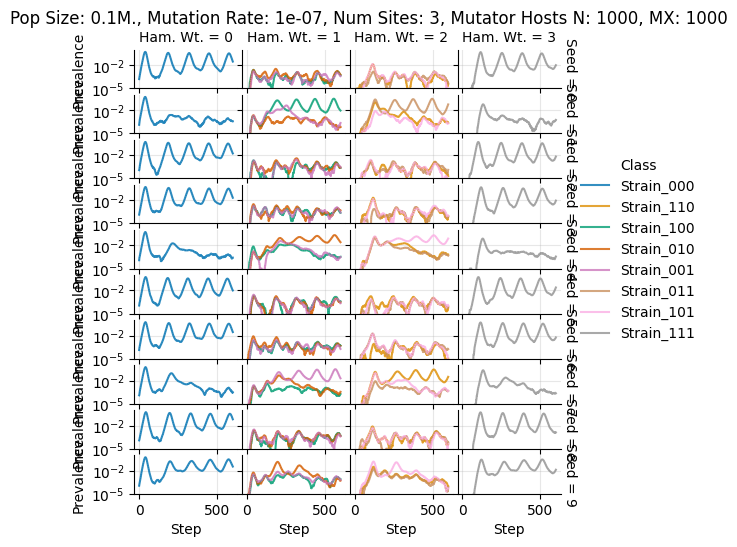

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+row=seed+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


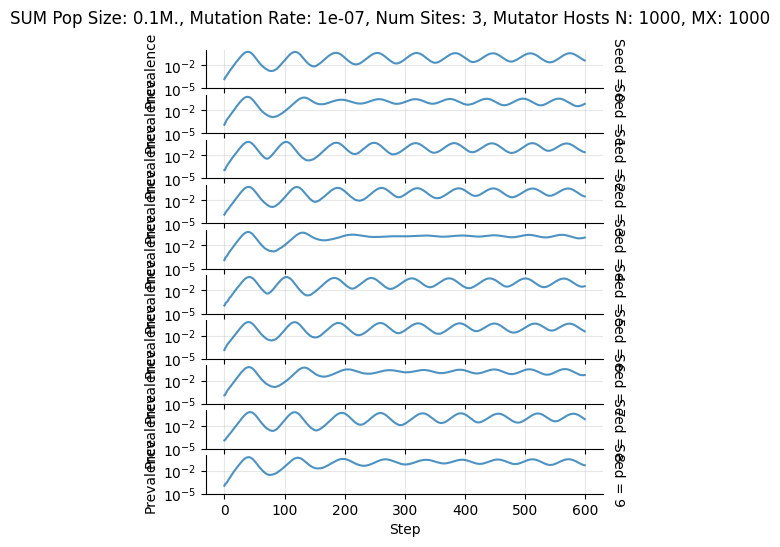

teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


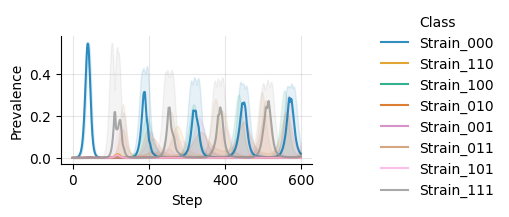

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


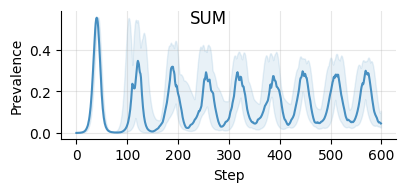

teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/col=ham-wt+hue=class+kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


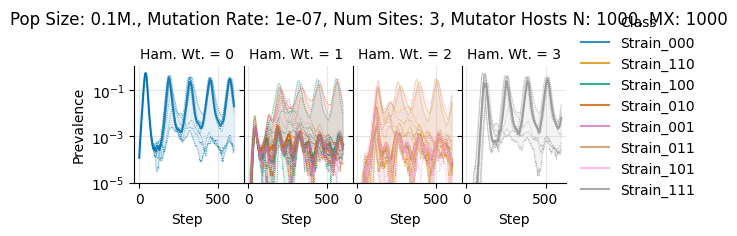

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.pdf
teeplots/2026-02-09-allele-abm/kind=line+mutation_rate=1e-07+mutator_hosts_mx=1000+mutator_hosts_n=1000+n_sites=3+pop_size=100000+viz=relplot+what=Strain+x=step+y=prevalence+ext=.png


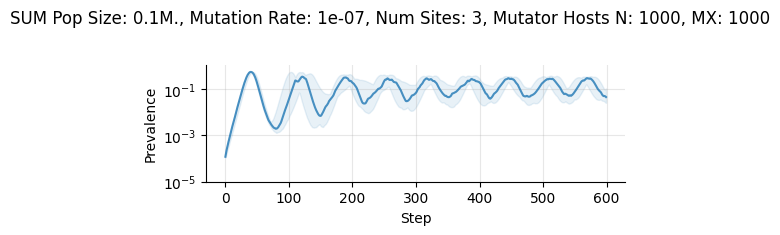

100%|██████████| 2/2 [05:15<00:00, 157.91s/it]


In [8]:
N_REP = 10
N_STEPS = 600
condition_matrix = it.product(
  [1e-7],  # MUTATION_RATE
  [100_000],  # POP_SIZE
  [0, 1_000],  # MUTATOR_HOSTS_N
  [1_000],  # MUTATOR_HOSTS_MX
  [3],  #N_SITES
)
for MUTATION_RATE, POP_SIZE, MUTATOR_HOSTS_N, MUTATOR_HOSTS_MX, N_SITES in tqdm(
    [*condition_matrix],
):
    suptitle = (
      f"Pop Size: {POP_SIZE / 1_000_000}M., "
      f"Mutation Rate: {MUTATION_RATE}, "
      f"Num Sites: {N_SITES}, "
      f"Mutator Hosts N: {MUTATOR_HOSTS_N}, "
      f"MX: {MUTATOR_HOSTS_MX}"
    )
    display_html(f"<h2>{suptitle}</h2>", raw=True)
    dfs = [
        simulate(
            MUTATION_RATE=MUTATION_RATE,
            N_SITES=N_SITES,
            N_STEPS=N_STEPS,
            POP_SIZE=POP_SIZE,
            seed=rep,
            MUTATOR_HOSTS_N=MUTATOR_HOSTS_N,
            MUTATOR_HOSTS_MX=MUTATOR_HOSTS_MX,
        )
        for rep in range(N_REP)
    ]
    df = pd.concat(dfs)
    render_timeseries_plots(
        df=df,
        suptitle=suptitle,
        teeplot_outattrs={
            "MUTATION_RATE".lower(): MUTATION_RATE,
            "N_SITES".lower(): N_SITES,
            "POP_SIZE".lower(): POP_SIZE,
            "MUTATOR_HOSTS_N".lower(): MUTATOR_HOSTS_N,
            "MUTATOR_HOSTS_MX".lower(): MUTATOR_HOSTS_MX,
        },
    )
